# Jessica's Charts

In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Anxiety_Level,Depression_Level,Insomnia_Level,OCD_Level,Date,Time,Time of Day,Musical_hobbies,Age_Grouped,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Low,Low,Low,Low,2022-08-27,19:29:02,Evening,Yes,18.0,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,High,Low,Low,Low,2022-08-27,19:57:31,Evening,No,63.0,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,High,High,High,Low,2022-08-27,21:28:18,Evening,No,18.0,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,High,High,Low,Low,2022-08-27,21:40:40,Evening,Yes,61.0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,High,Low,Medium,High,2022-08-27,21:54:47,Evening,No,18.0,10


In [3]:
mxmh_scores = mxmh.melt(id_vars=["Timestamp", "Age", "Music effects"], 
                     value_vars=["Anxiety", "Depression", "Insomnia", "OCD"], 
                     var_name="Mental Health Condition", 
                     value_name="Self-report Score")

# What are the response patterns self-reported mental health severities?

For the visualization below, select the **Mental Health Condition** to look at a condition of interest.
Use `shift` + click to select multiple categories.

## Option A

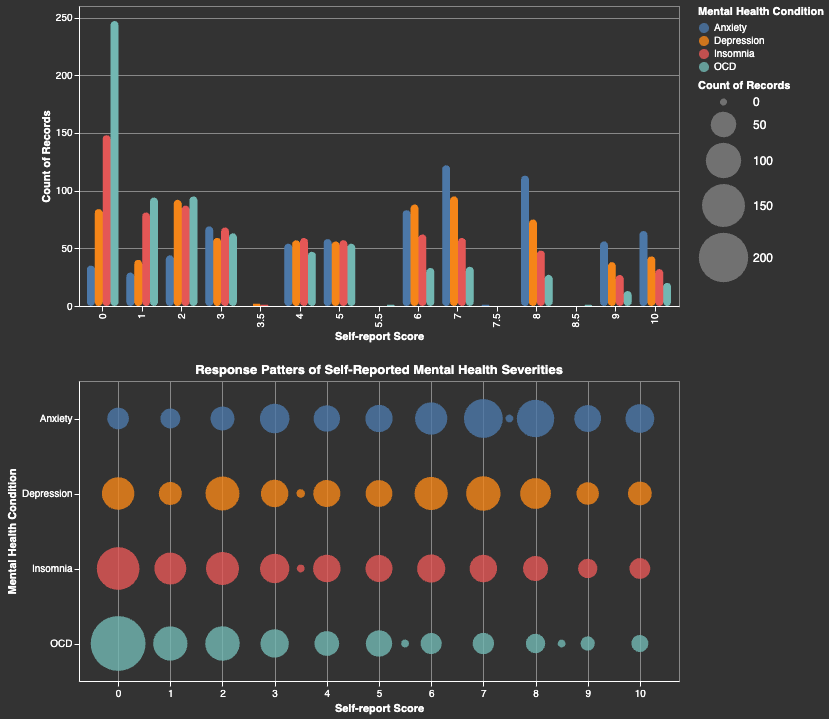

In [4]:
# Create a parameter, checkbox
selection = alt.selection_point(fields=['Mental Health Condition'], bind='legend')

# Create a violin plot
multibar = alt.Chart(mxmh_scores).mark_bar(cornerRadius=7).encode(
    x=alt.X('Self-report Score:O'),
    xOffset="Mental Health Condition:N",
    y='count():Q',
    color=alt.condition(selection, 'Mental Health Condition:N', alt.value('grey')),
    tooltip=["Mental Health Condition", "count()"]
).properties(width=600, height=300)

# Create a boxplot
dotplot = alt.Chart(mxmh_scores, title="Response Patters of Self-Reported Mental Health Severities").add_params(
    selection
).mark_circle(opacity=0.8).encode(
    x=alt.X('Self-report Score:Q', title="Self-report Score", scale=alt.Scale(domain=[-0.75, 10.75])),
    y=alt.Y('Mental Health Condition:N', title="Mental Health Condition"),
    color=alt.condition(selection, 'Mental Health Condition:N', alt.value('grey')),
    size = alt.Size("count():Q", scale=alt.Scale(rangeMin=50, rangeMax=3000), legend=alt.Legend(labelFontSize=12)),
    tooltip=["Self-report Score", "count()"]
).properties(width=600, height=300)

alt.vconcat(multibar, dotplot)

## Option B

For the visualization below, drag your cursor across the screen to highlight sections of the histogram and dot-chart.

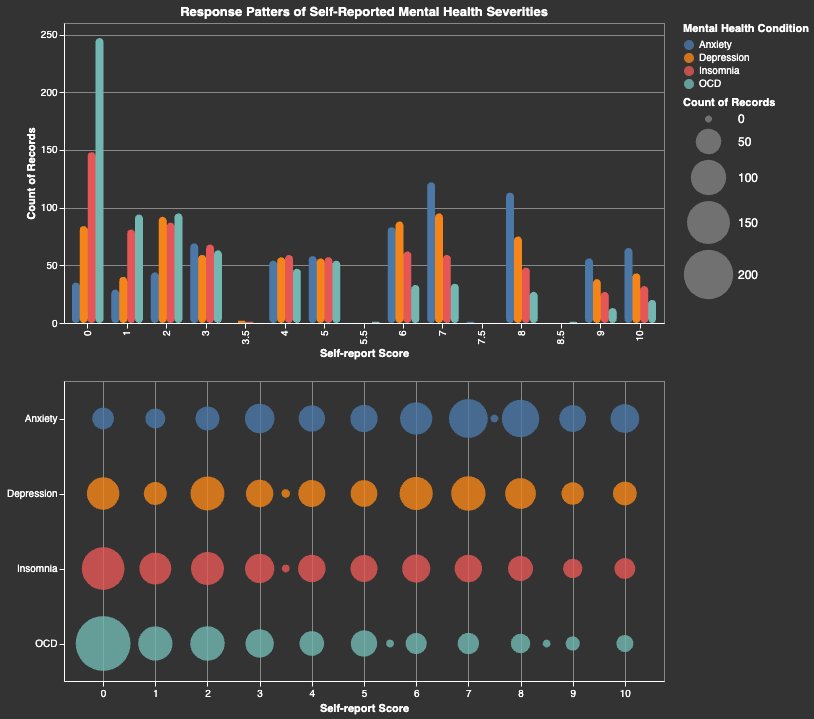

In [5]:
# Create a parameter, checkbox
brush = alt.selection_interval(
    # encodings=['x']
)

# Create a multi-bar plot
multibar = alt.Chart(mxmh_scores, title="Response Patters of Self-Reported Mental Health Severities").add_params(
    brush
).mark_bar(cornerRadius=7).encode(
    x=alt.X('Self-report Score:O'),
    xOffset="Mental Health Condition:N",
    y='count():Q',
    color=alt.when(brush).then("Mental Health Condition:N").otherwise(alt.value("gray")),
    tooltip=["Mental Health Condition", "count()"]
).properties(width=600, height=300)

# Create a box-plot
dotplot = alt.Chart(mxmh_scores).add_params(
    brush
).mark_circle(opacity=0.8).encode(
    x=alt.X('Self-report Score:Q', title="Self-report Score", scale=alt.Scale(domain=[-0.75, 10.75])),
    y=alt.Y('Mental Health Condition:N', title=""),
    color=alt.when(brush).then("Mental Health Condition:N").otherwise(alt.value("gray")),
    size = alt.Size("count():Q", scale=alt.Scale(rangeMin=50, rangeMax=3000), legend=alt.Legend(labelFontSize=12)),
    tooltip=["Self-report Score", "count()"]
).properties(width=600, height=300)

alt.vconcat(multibar, dotplot)

## What is the distribution of self-reported mental health scores based on opinions of music on mental health?

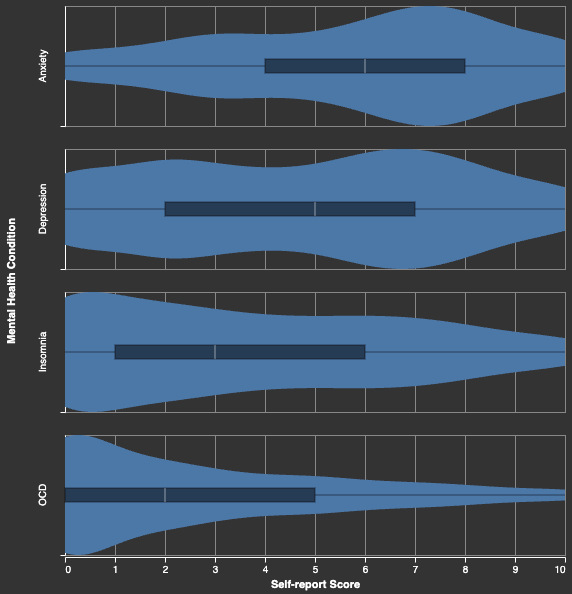

In [6]:
# options = ['Violin', 'Boxplot']
# labels = [option + ' ' for option in options]

# input_dropdown = alt.binding_radio(
#     options=options + [None],
#     labels=labels + ['Violin & Boxplot'],
#     name='Type: '
# )

# UI widget 
selection = alt.selection_point(fields=['Music effects'], bind='legend')

# Box-plot
boxplot = alt.Chart().mark_boxplot(box={'stroke': 'black'}, color='black', opacity=0.5).encode(
	alt.X('Self-report Score:Q')
).properties(width=500)

# Violin-plot
violin = alt.Chart().transform_density(
	'Self-report Score',
	as_=['Self-report Score', 'density'],
	extent=[0, 10],
	groupby=['Mental Health Condition']
).mark_area(orient='vertical').encode(
	x='Self-report Score:Q',
	y=alt.Y('density:Q', stack='center', impute=None, title=None,
            scale=alt.Scale(nice=False, zero=True),
            axis=alt.Axis(labels=False, values=[0], grid=False, ticks=True)),
).properties(width=500, height=120)

# Combining both charts
chart = alt.layer(
    violin,
    boxplot,
    data=mxmh_scores
).facet(row='Mental Health Condition:N'
).resolve_scale(y=alt.ResolveMode("independent"))

chart.show()

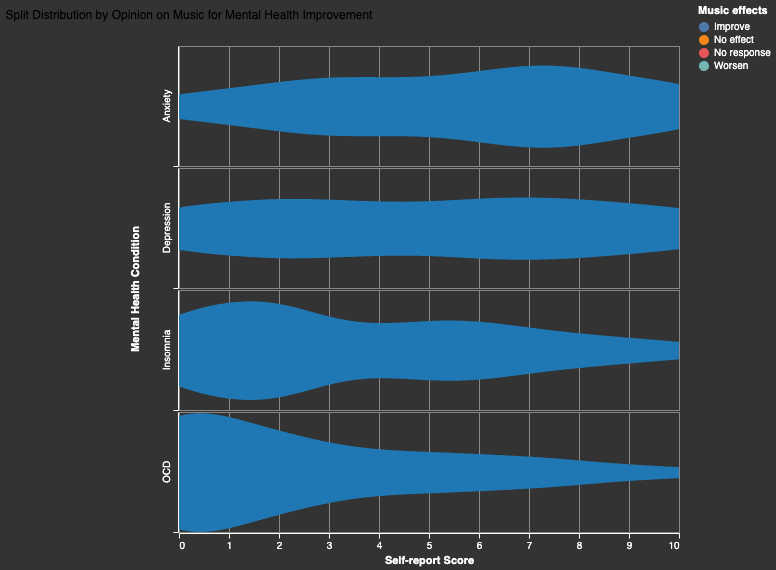

In [7]:
bind_checkbox = alt.binding_checkbox(name='Split Distribution by Opinion on Mudic for Mental Health Improvement: ')
param_checkbox = alt.param(bind=bind_checkbox)

# Create a violin plot
violin = alt.Chart(mxmh_scores, width=100).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    x=alt.X('Self-report Score:Q'),
    y=alt.Y('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    row=alt.Row('Mental Health Condition:N').spacing(0).header(titleOrient='left', labelOrient='left', labelPadding=0),
    color=alt.condition(param_checkbox, 'Music effects:N', alt.value("#1f77b4")),
).properties(width=500, height=120).add_params(param_checkbox)


text = pd.DataFrame({"label": ["Split Distribution by Opinion on Music for Mental Health Improvement",
                               ],})
text

alt.vconcat(alt.Chart(text).mark_text(align='center',fontSize=12,
    ).encode(text="label").add_params(param_checkbox),
    violin
)

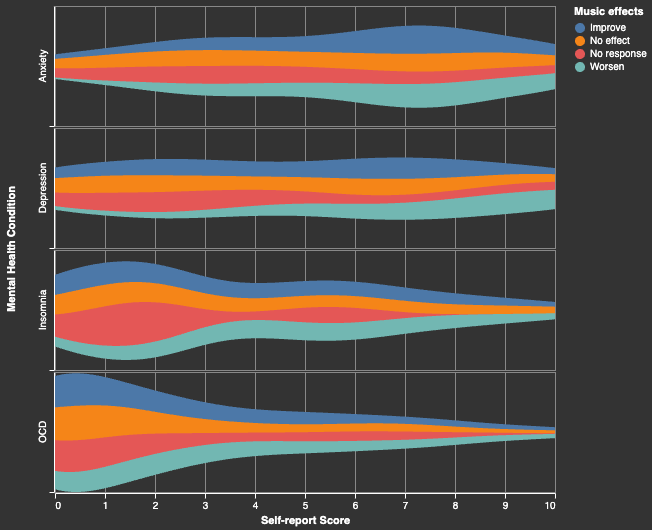

In [8]:
selection = alt.selection_point(fields=['Music effects'], bind='legend')

# Create a violin plot
violin = alt.Chart(mxmh_scores, width=100).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    x=alt.X('Self-report Score:Q'),
    y=alt.Y('density:Q').stack('center').impute(None).title(None).axis(labels=False, values=[0], grid=False, ticks=True),
    row=alt.Row('Mental Health Condition:N').spacing(0).header(titleOrient='left', labelOrient='left', labelPadding=0),
    color=alt.condition(selection, 'Music effects:N', alt.value("grey")),
).properties(width=500, height=120).add_params(selection)

violin

In [9]:
# Create a violin plot
violin = alt.Chart(mxmh_scores).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[-0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    y=alt.Y('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    x=alt.X('Self-report Score:Q')
)

# Create a boxplot
boxplot = alt.Chart(mxmh_scores).mark_boxplot(box={'stroke': 'black'}, size=40, opacity=0.8).encode(
    y=alt.Y('Mental Health Condition:N', title=""),
    x=alt.X('Self-report Score:Q', title="Self-report Score"),
    color=alt.Color("Mental Health Condition:N", legend=None),
    tooltip=["Mental Health Condition", "Self-report Score"]
).properties(width=400, height=400)

# Layer both plots
final_chart = alt.hconcat(violin, boxplot).resolve_scale(x='shared')

# final_chart.show()

# What are the anomolies in self-reported mental health severities?

# Can we group individuals into clusters based on their music preferences and mental health scores?

In [10]:
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Anxiety_Level,Depression_Level,Insomnia_Level,OCD_Level,Date,Time,Time of Day,Musical_hobbies,Age_Grouped,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Low,Low,Low,Low,2022-08-27,19:29:02,Evening,Yes,18.0,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,High,Low,Low,Low,2022-08-27,19:57:31,Evening,No,63.0,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,High,High,High,Low,2022-08-27,21:28:18,Evening,No,18.0,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,High,High,Low,Low,2022-08-27,21:40:40,Evening,Yes,61.0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,High,Low,Medium,High,2022-08-27,21:54:47,Evening,No,18.0,10


In [11]:
# from IPython.display import display, HTML

# display(HTML("""
# <style>
# form.vega-bindings {
#   position: absolute;
#   right: -100px;
#   top: 0px;
# }
# </style>
# """))

## Option A - from PM2

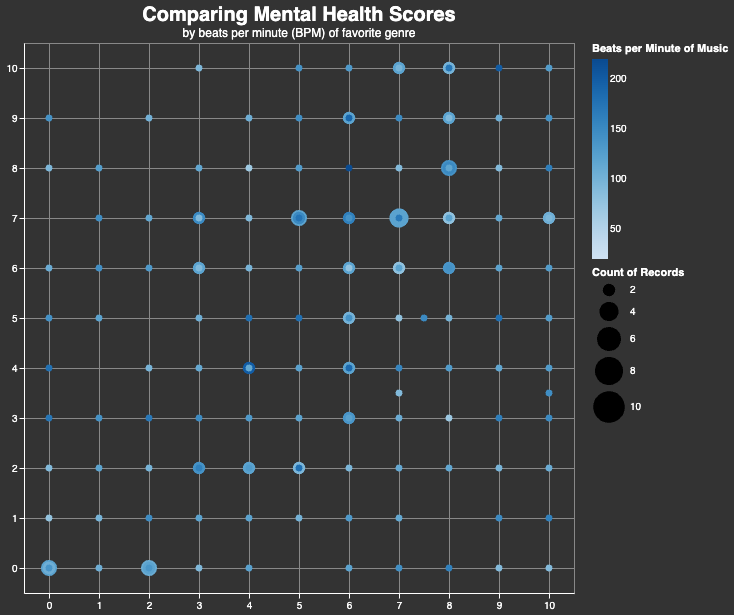

In [12]:
dropdown_x = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='X-axis column '
)

dropdown_y = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Y-axis column '
)

# dropdown for X column
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown_x
)

# dropdown for Y column
ycol_param = alt.param(
    value='Depression',
    bind=dropdown_y
)

# Chart
alt.Chart(mxmh).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(''),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(""),
    color=alt.Color('BPM:Q').title('Beats per Minute of Music'),
    size=alt.Size("count()", scale=alt.Scale(domain=[1, 10], rangeMin=50, rangeMax=1000)),
    tooltip=["count()"]
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
    x=f'datum[{xcol_param.name}]',
).add_params(
    ycol_param,
    xcol_param,
).properties(title=alt.Title("Comparing Mental Health Scores", 
                             subtitle="by beats per minute (BPM) of favorite genre",
                             fontSize=20), 
             width=550, 
             height=550)

## Option B

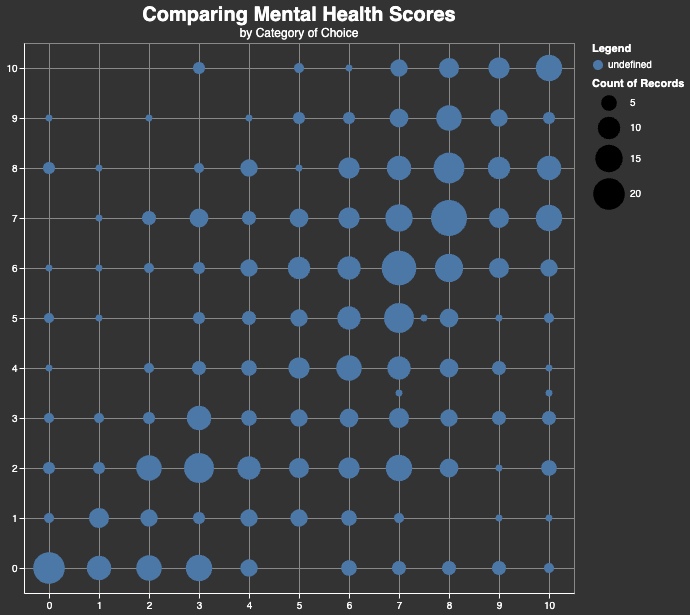

In [13]:
dropdown_x = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='X-axis column '
)

dropdown_y = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Y-axis column '
)

dropdown_legend = alt.binding_select(
    options=[None]+["Primary streaming service",
                    "While working",
                    "Instrumentalist",
                    "Composer",
                    "Exploratory",
                    "Foreign languages",
                    "Music effects"
                   ],
    labels=["None"]+["Primary streaming service",
                    "While working",
                    "Instrumentalist",
                    "Composer",
                    "Exploratory",
                    "Foreign languages",
                    "Music Effects on Mental Health"
                   ],
    name='Legend: '
)

# dropdown for X column
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown_x
)

# dropdown for Y column
ycol_param = alt.param(
    value='Depression',
    bind=dropdown_y
)

# dropdown for legend
legend_param = alt.param(
    value='Streaming Service',
    bind=dropdown_legend
)

# Chart
alt.Chart(mxmh).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(''),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(""),
    color=alt.Color('color:N').title('Legend'),
    size=alt.Size("count()", scale=alt.Scale(domain=[1, 20], rangeMin=50, rangeMax=1000)),
    tooltip=["count()"]
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
    x=f'datum[{xcol_param.name}]',
    color=f'datum[{legend_param.name}]'
).add_params(
    ycol_param,
    xcol_param,
    legend_param
).properties(title=alt.Title("Comparing Mental Health Scores", 
                             subtitle="by Category of Choice", fontSize=20), 
             width=550, 
             height=550)

## Option C

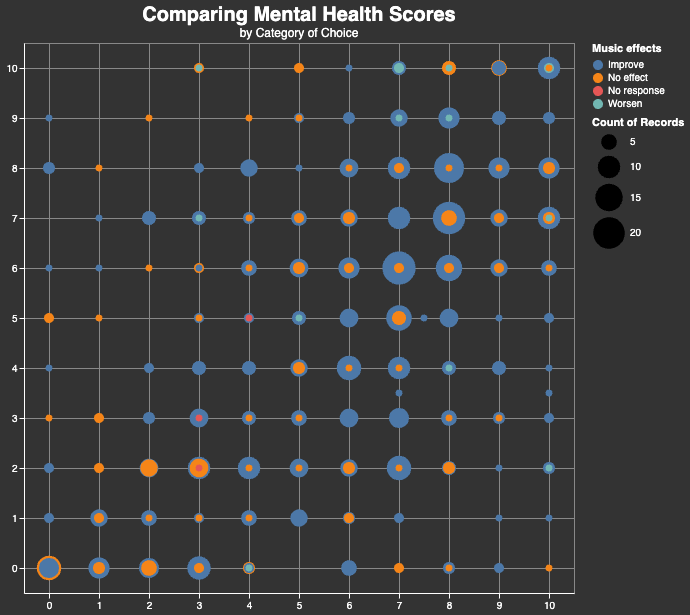

In [14]:
dropdown_x = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='X-axis column '
)

dropdown_y = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Y-axis column '
)

# dropdown for X column
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown_x
)

# dropdown for Y column
ycol_param = alt.param(
    value='Depression',
    bind=dropdown_y
)

# Chart
alt.Chart(mxmh).mark_circle().encode(
    x=alt.X('x:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(''),
    y=alt.Y('y:Q', scale=alt.Scale(domain=[-0.5, 10.5])).title(""),
    color=alt.Color('Music effects:N'),
    size=alt.Size("count()", scale=alt.Scale(domain=[1, 20], rangeMin=50, rangeMax=1000)),
    tooltip=["count()", 'Music effects:N']
).transform_calculate(
    y=f'datum[{ycol_param.name}]',
    x=f'datum[{xcol_param.name}]',
).add_params(
    ycol_param,
    xcol_param,
).properties(title=alt.Title("Comparing Mental Health Scores", 
                             subtitle="by Category of Choice",
                             fontSize=20), 
             width=550, 
             height=550)